In [1]:
import sys, os, laspy, time, copy
import numpy as np
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.spatial import KDTree
from scipy import linalg, interpolate, ndimage

### Read las files and do some pre-processing (clipping, determining grid size, making "points_map"
- fn = '20201002_VLP32C_ICSC.las'
- fn = '20200827_Riegl_Calib.las'

In [2]:
fn = '20201002_VLP32C_ICSC.las'
#fn = '20200827_Riegl_Calib.las'
las_fn = os.getcwd() + '/'+fn
las = laspy.file.File(las_fn, mode = 'r')
points = np.vstack((las.x, las.y, las.z)).transpose()
las.close()

# Check number of points
num_points = points.shape[0]
print("number of points:", num_points)

number of points: 23207362


In [3]:
# Clipping target areas by removing the boundary points with a "Bound_off_rate".
# Bound_off_rate was set to 10%
# Therefore, only the points of middle 80% for each X and Y coordinates are used for the post data-processing 
# by excluding the top 10% and the bottom 10%.

Bound_off_rate = 0.1

min_x = np.sort(points[:,0])[int(len(points)*Bound_off_rate)]
max_x = np.sort(points[:,0])[int(len(points)*(1-Bound_off_rate))]
min_y = np.sort(points[:,1])[int(len(points)*Bound_off_rate)]
max_y = np.sort(points[:,1])[int(len(points)*(1-Bound_off_rate))]
X_len = max_x - min_x
Y_len = max_y - min_y

# XY ranges to consider
print("X ranges to consider {} - {}:".format(min_x,max_x))
print("Y ranges to consider {} - {}:".format(min_y,max_y))
print("Areas X({}m) by Y({}m)".format(X_len,Y_len))

X ranges to consider 500413.118 - 500482.031:
Y ranges to consider 4479897.633 - 4479964.793:
Areas X(68.91300000000047m) by Y(67.15999999921769m)


### Determining Cell Size

In [4]:
#scale_factor = 1 ## cell = 1 meter by 1 meter
#scale_factor = 2 ## cell = 2 meter by 2 meter
scale_factor = 0.5 ## cell = 0.5 meter by 0.5 meter

In [5]:
ul_x = min_x
ul_y = max_y
cs_x = 1
cs_y = -1

# number of row and column at cell size of 1 meter by 1 meter 
nrow = int(Y_len)
ncol = int(X_len)

# umber of row and column after Downscaling
nrow_out = int(nrow/scale_factor)
ncol_out = int(ncol/scale_factor)
cs_x_out = cs_x*scale_factor # cell size
cs_y_out = cs_y*scale_factor

print("number of Row and Column after Downsampling: {} and {}".format(nrow_out, ncol_out))

number of Row and Column after Downsampling: 134 and 136


### Making an array consisting of [X,Y,Z, Column index, Row index]

In [6]:
lidar = np.zeros((num_points,5))
#x,y,z
lidar[:,0:3] = points[:,:]
#col
lidar[:,3] = (lidar[:,0]-ul_x)/cs_x_out
#row
lidar[:,4] = (lidar[:,1]-ul_y)/cs_y_out

## Creating "points_map"
### points_map is 3D array: `[Row_index][Col_index][Points coordinates in each cell]`

In [7]:
points_map=[]
for i in range(nrow_out):
    points_map.append([[].append([]) for x in range(ncol_out)])
for i in range(nrow_out):
    for j in range(ncol_out):
        points_map[i][j] = []

# For each LiDAR point
pbar = ProgressBar() # if you have Progressbar ...
for i in pbar(range(num_points)):
    col = int(lidar[i,3])
    row = int(lidar[i,4])
    
    # Check the points are within boundary
    # if point does not fall within boundary, skip   
    if col < 0 or col >= ncol_out:
        continue
    if row < 0 or row >= nrow_out:
        continue
        
    points_map[row][col].append(lidar[i,:3])

100% |########################################################################|


In [8]:
# Example of points_map
# points_map of row = 0, col = 0 consits of these points
points_map[0][0]

[array([5.00412672e+05, 4.47996436e+06, 1.81402000e+02]),
 array([5.00412661e+05, 4.47996451e+06, 1.81406000e+02]),
 array([5.00412649e+05, 4.47996465e+06, 1.81399000e+02]),
 array([5.00412638e+05, 4.47996480e+06, 1.81396000e+02]),
 array([5.00412625e+05, 4.47996495e+06, 1.81410000e+02]),
 array([5.00413266e+05, 4.47996433e+06, 1.81422000e+02]),
 array([5.00413255e+05, 4.47996448e+06, 1.81414000e+02]),
 array([5.00413242e+05, 4.47996463e+06, 1.81430000e+02]),
 array([5.00413231e+05, 4.47996478e+06, 1.81415000e+02]),
 array([5.00413220e+05, 4.47996492e+06, 1.81417000e+02]),
 array([5.00413208e+05, 4.47996506e+06, 1.81423000e+02]),
 array([5.00413198e+05, 4.47996520e+06, 1.81410000e+02]),
 array([5.00412839e+05, 4.47996432e+06, 1.81419000e+02]),
 array([5.00412827e+05, 4.47996447e+06, 1.81411000e+02]),
 array([5.00412815e+05, 4.47996462e+06, 1.81404000e+02]),
 array([5.00412804e+05, 4.47996477e+06, 1.81409000e+02]),
 array([5.00412792e+05, 4.47996491e+06, 1.81419000e+02]),
 array([5.0041

# Task1: Point Density
### Point Density Map counts the number of point clouds in each cell using the "points_map" defined above.

In [9]:
Point_Density=[]
for i in range(nrow_out):
    Point_Density.append([[].append([]) for x in range(ncol_out)])
for i in range(nrow_out):
    for j in range(ncol_out):
        Point_Density[i][j] = []

pbar = ProgressBar() # if you have Progressbar ...
for i in pbar(range(nrow_out)):
    for j in range(ncol_out):
    
        if len(points_map[i][j])!=0:
            Point_Density[i][j] = len(np.array(points_map[i][j]))
        else:
            Point_Density[i][j] = np.nan ## where there is no point!!

100% |########################################################################|


# Visualizing Point Desnity Map

<Figure size 432x288 with 0 Axes>

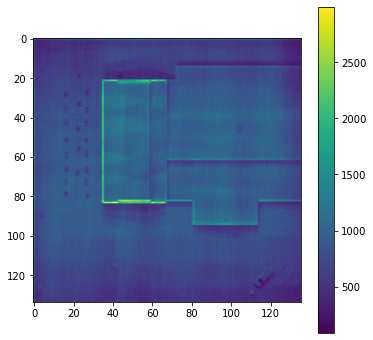

In [10]:
plt.figure()
figure(figsize=(6, 6))
plt.imshow(Point_Density)
plt.colorbar()

# Task2: Digital Surface Model (DSM)
### Sorting the Z coordinates in each cell and take 90th percentile value using the "points_map".

## DSM (90 Percentile)

In [11]:
DSM_90=[]
for i in range(nrow_out):
    DSM_90.append([[].append([]) for x in range(ncol_out)])
for i in range(nrow_out):
    for j in range(ncol_out):
        DSM_90[i][j] = []

pbar = ProgressBar()
for i in pbar(range(nrow_out)):
    for j in range(ncol_out):
        if len(points_map[i][j])!=0:
            DSM_90[i][j]=np.sort(np.array(points_map[i][j])[:,2])[int(len(np.array(points_map[i][j])[:,2])*0.90)]
        else:
            DSM_90[i][j]=np.nan ## Assign Nan value where there is no point.

100% |########################################################################|


## Filling empty cell with nearest neigbor

Text(0.5, 1.0, 'DSM_90_NN')

<Figure size 432x288 with 0 Axes>

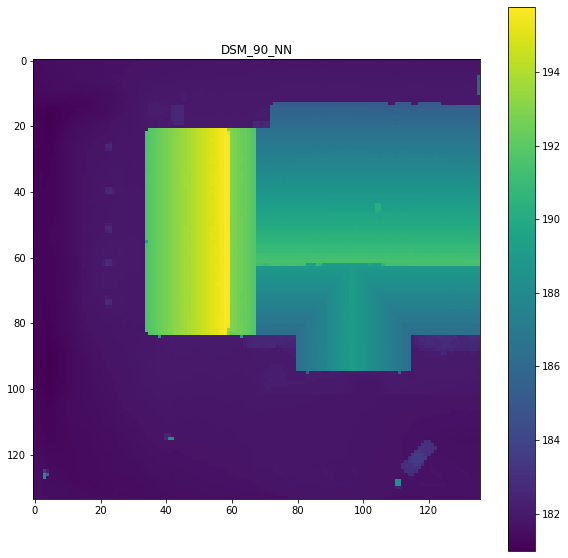

In [12]:
DSM_90_arr = np.array(DSM_90)

## Nearest Interpolation
temp = copy.deepcopy(DSM_90_arr)
x = np.arange(0, temp.shape[1])
y = np.arange(0, temp.shape[0])
#mask invalid values
temp = np.ma.masked_invalid(temp)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~temp.mask]
y1 = yy[~temp.mask]
newarr = temp[~temp.mask]

DSM_90_NN = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='nearest')

plt.figure()
figure(figsize=(10, 10))
plt.imshow(DSM_90_NN)
plt.colorbar()
plt.title('DSM_90_NN')

## Filling empty cell with nearest neigbor (from scratch)

Text(0.5, 1.0, 'DSM_90_NN2')

<Figure size 432x288 with 0 Axes>

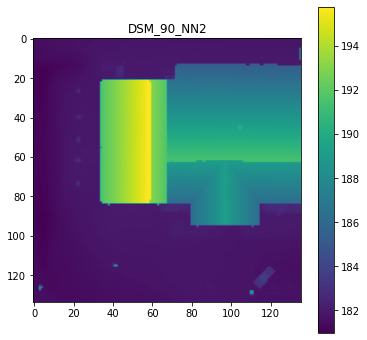

In [13]:
def create_square_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    #X, Y = np.ogrid[:h, :w]
    #dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    temp = np.zeros([h,w])
    temp[center[0]-radius:center[0]+radius,center[1]-radius:center[1]+radius] = 1
    nan_mask = temp.astype(float)
    nan_mask[nan_mask==0]=np.nan
    return nan_mask

def NearestNeighbors(IMG, R=1, P=1):
    
    img = copy.deepcopy(IMG)
    h, w = img.shape[:2]

    interpolated_img = np.zeros([h,w])

    # find nan
    number_of_interpolated_points = 0

    while np.sum(np.isnan(img)) != 0:

        NROW_NCOL = []
        pbar = ProgressBar() # if you have Progressbar ...

        for i in pbar(range(np.sum(np.isnan(img)))):
            number_of_interpolated_points = number_of_interpolated_points+1
            (row,col) = (np.where(np.isnan(img))[0][i],np.where(np.isnan(img))[1][i])  
            mask = create_square_mask(h, w, center = (row,col), radius = R)


            if np.sum(~np.isnan(img*mask)) != 0: # if nearest point exists
                DIST = []
                Z = []

                for j in range(np.sum(~np.isnan(img*mask))):
                    nrow,ncol = np.where(~np.isnan(img*mask))[0][j],np.where(~np.isnan(img*mask))[1][j]

                    # distance to a nearest point
                    dist = np.sqrt((row - nrow)**2 + (col - ncol)**2)
                    # intensity (height) of the nearest point
                    z = img[nrow,ncol]
                    # coordinates of interpolated pixel
                    nrow_ncol = [row, col]

                    DIST.append(dist)
                    Z.append(z)


                DIST = np.array(DIST)
                Z = np.array(Z)
                NROW_NCOL.append(nrow_ncol)

                interpolated_img[row,col] = np.sum(Z * (DIST**P)/np.sum(DIST**P))

        print("number_of_interpolated_points:", number_of_interpolated_points)


        for k in range(len(NROW_NCOL)):
            img[NROW_NCOL[k][0],NROW_NCOL[k][1]] = interpolated_img[NROW_NCOL[k][0],NROW_NCOL[k][1]]
            
    return img

DSM_90_NN2 = NearestNeighbors(DSM_90_arr)

plt.figure()
figure(figsize=(6, 6))
plt.imshow(DSM_90_NN2)
plt.colorbar()
plt.title('DSM_90_NN2')

## Apply Median Filter

In [14]:
def crop_neighbors(IMG, IDX, KERNEL_SZ=5):
    (i,j) = IDX
    neighbors = []
    pad_size = int(np.floor(KERNEL_SZ/2))
    
    for m in range(2*pad_size+1):
        for n in range(2*pad_size+1):
            if IMG[i-pad_size+m,j-pad_size+n]!=-1:
                neighbors.append(IMG[i-pad_size+m,j-pad_size+n])
    
    return np.array(neighbors)

def median_filter(IMG, kernel_sz=5):
    
    pad_size = int(np.floor(kernel_sz/2))
    H = IMG.shape[0]
    W = IMG.shape[1]
    pad_img = np.ones((H+2*pad_size,W+2*pad_size))*-1

#     plt.figure()
#     plt.imshow(pad_img)
#     plt.colorbar()

    pad_img[pad_size:pad_size+H,pad_size:pad_size+W] = IMG
#     plt.figure()
#     plt.imshow(pad_img)
#     plt.colorbar()

    MED_IMG = np.zeros((H,W))

    pbar = ProgressBar() # if you have Progressbar ...
    for h in pbar(range(H)): # 
        for w in range(W):
            idx = (h+pad_size,w+pad_size)
            MED_IMG[h,w] = np.median(crop_neighbors(pad_img, IDX=idx, KERNEL_SZ = kernel_sz))

#     plt.figure()
#     plt.imshow(MED_IMG)
#     plt.colorbar()  
    
    return MED_IMG

100% |########################################################################|


<Figure size 432x288 with 0 Axes>

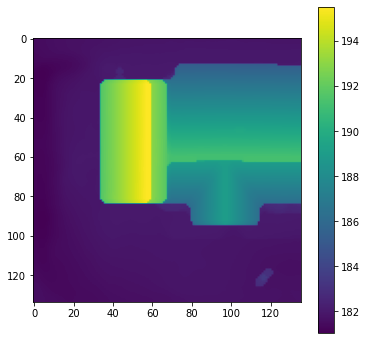

In [15]:
DSM_90_NN_med = median_filter(DSM_90_NN, kernel_sz=5)

fig = plt.figure()
figure(figsize=(6, 6))
plt.imshow(DSM_90_NN_med)
plt.colorbar()

### Saving DSM to show in CloudCompare

In [16]:
# 2D DSM array to 3D DSM (x,y,z)
DSM_90_NN_med_xyz = []
for i in range(DSM_90_NN_med.shape[0]):
    for j in range(DSM_90_NN_med.shape[1]):
        xx[i][j],yy[i][j],DSM_90_NN_med[i][j]
        DSM_90_NN_med_xyz.append(xx[i][j]*scale_factor)
        DSM_90_NN_med_xyz.append(yy[i][j]*scale_factor)
        DSM_90_NN_med_xyz.append(DSM_90_NN_med[i][j])
DSM_90_NN_med_xyz=np.reshape(np.array(DSM_90_NN_med_xyz),[-1,3])

In [18]:
np.savetxt('DSM_{}_{}.csv'.format(fn,scale_factor), DSM_90_NN_med_xyz, delimiter=',')
print('DSM_{}_{}.csv'.format(fn,scale_factor))

DSM_20201002_VLP32C_ICSC.las_0.5.csv


# Task3: Point Cloud Classification
### Calculated eigenvalue using principal component analysis, considering each point's local neighborhood as a feature space, was used to clasify the point cloud

## Down-sampling
#### Before performing point cloud classification, down-sampling was performed to reduce the computational time and make points cloud be more uniformly distributed points.
#### After the downsampling, each cell will not contain no more than 3 points.

In [19]:
# shuffle the order of the points cloud
# lidar = np.random.shuffle(lidar)

points_map_down=[]
for i in range(nrow_out):
    points_map_down.append([[].append([]) for x in range(ncol_out)])
for i in range(nrow_out):
    for j in range(ncol_out):
        points_map_down[i][j] = []

# For each LiDAR point
pbar = ProgressBar()
for i in pbar(range(num_points)):
    col = int(lidar[i,3])
    row = int(lidar[i,4])
    
    # Check all the points are within boundary
    # if point does not fall within boundary, skip    
    if col < 0 or col >= ncol_out:
        continue
    if row < 0 or row >= nrow_out:
        continue
    
    ## Each grid should not contain no more than "10*scale_factor*scale_factor" points.
    ## For our case, scale_factor was set to 0.5.
    ## Therefore, after the downsampling, each cell will not contain no more than 3 points.
    if len(points_map_down[row][col])>10*scale_factor*scale_factor:
        continue
    else:
        points_map_down[row][col].append(lidar[i,:3])

100% |########################################################################|


In [20]:
## show an example of points clouds in the cell of [row,col] = [10, 15]
points_map_down[10][15]

[array([5.00421077e+05, 4.47995941e+06, 1.81346000e+02]),
 array([5.00421054e+05, 4.47995956e+06, 1.81365000e+02]),
 array([5.00421033e+05, 4.47995971e+06, 1.81377000e+02])]

#### This cell is simply for converting the down-sampled lidar points to have a shape of [X,Y,Z]

In [21]:
points_down=[]
for i in range(nrow_out):
    for j in range(ncol_out):
        points_down.append(points_map_down[i][j])

# list in list to list to array
# flat_list = [item for sublist in t for item in sublist]
points_down_flat = []
for sublist in points_down:
    for item in sublist:
        points_down_flat.append(item)

points_down_flat = np.array(points_down_flat)

In [22]:
points_down_flat

array([[5.00412672e+05, 4.47996436e+06, 1.81402000e+02],
       [5.00412661e+05, 4.47996451e+06, 1.81406000e+02],
       [5.00412649e+05, 4.47996465e+06, 1.81399000e+02],
       ...,
       [5.00481083e+05, 4.47989819e+06, 1.81714000e+02],
       [5.00481095e+05, 4.47989785e+06, 1.81694000e+02],
       [5.00480751e+05, 4.47989815e+06, 1.81586000e+02]])

In [23]:
print("Downsampled point clouds have only {} points".format(len(points_down_flat)))

Downsampled point clouds have only 54672 points


## Constructing KDTree
#### dist: distance to the nearest points for every points
#### ind: index of nearest points for every points

In [24]:
N=100
start_time = time.time()
tree = KDTree(points_down_flat, leafsize = 100)              
dist, ind = tree.query(points_down_flat[:], k=N)
print("Takes {} seconds".format(time.time()-start_time))

Takes 45.92299962043762 seconds


## Calculating the centorid coordinates of N neighbors for every points

In [25]:
centroid_list=[]
pbar = ProgressBar()
for i in pbar(range(len(ind))):
    nearest_sum=0
    for j in range(N):
        nearest_sum = nearest_sum+points_down_flat[ind[i][j]]
    centroid_list.append(nearest_sum/N)

100% |########################################################################|


## Classifying the point by calculating the eigenvalues

In [26]:
classification = []

pbar = ProgressBar()
for i in pbar(range(len(points_down_flat))):
    Dispersion=np.zeros([3,3])
    for j in range(N):
        dis = points_down_flat[ind[i][j]]-centroid_list[i]
        Dispersion = Dispersion + np.matmul(dis.reshape(3,1),dis.reshape(1,3))
    Dispersion=Dispersion/N
    
    # Largest eigenvalue
    l1=np.sort(linalg.eig(Dispersion)[0])[2] 
    # Median eigenvalue
    l2=np.sort(linalg.eig(Dispersion)[0])[1]
    # Smallest eigenvalue
    l3=np.sort(linalg.eig(Dispersion)[0])[0] 

    # Caculating the measures a1, a2, a3
    a1 = (np.sqrt(l1)-np.sqrt(l2))/np.sqrt(l1)
    a2 = (np.sqrt(l2)-np.sqrt(l3))/np.sqrt(l1)
    a3 = np.sqrt(l3)/np.sqrt(l1)

    # Classifying each point and assigning their label
    if max(a1,a2,a3)==a1: # linear (label:1)
        classification.append(1)
    elif max(a1,a2,a3)==a2: # planar (label:2)
        classification.append(2)
    elif max(a1,a2,a3)==a3: # rough (label:3)
        classification.append(3)
    else:
        print("error")

100% |########################################################################|


In [27]:
classification = np.array(classification)
#lidar --> points_class
points_class = np.zeros((len(classification),4))
#x,y,z
points_class[:,0:3] = points_down_flat[:,:3]
#class
points_class[:,3] = classification

In [28]:
# Proportions of each classes
print("linear (%): {:^2.3f}".format(np.sum(classification==1)/np.shape(points_class)[0]))
print("planar (%): {:^2.3f}".format(np.sum(classification==2)/np.shape(points_class)[0]))
print(" rough (%): {:^2.3f}".format(np.sum(classification==3)/np.shape(points_class)[0]))

linear (%): 0.009
planar (%): 0.988
 rough (%): 0.002


### Saving classified points to show in CloudCompare

In [29]:
# linear:1
linear = points_class[points_class[:,3] == 1]
np.savetxt('linear_{}_{}_{}.csv'.format(fn,N,scale_factor), linear, delimiter=',')
print('linear_{}_{}_{}.csv'.format(fn,N,scale_factor))

# planar:2
planar = points_class[points_class[:,3] == 2]
np.savetxt('planar_{}_{}_{}.csv'.format(fn,N,scale_factor), planar, delimiter=',')
print('planar_{}_{}_{}.csv'.format(fn,N,scale_factor))

# rough:3
rough = points_class[points_class[:,3] == 3]
np.savetxt('rough_{}_{}_{}.csv'.format(fn,N,scale_factor), rough, delimiter=',')
print('rough_{}_{}_{}.csv'.format(fn,N,scale_factor))

linear_20201002_VLP32C_ICSC.las_100_0.5.csv
planar_20201002_VLP32C_ICSC.las_100_0.5.csv
rough_20201002_VLP32C_ICSC.las_100_0.5.csv


In [30]:
np.savetxt('class_{}_{}_{}.csv'.format(fn,N,scale_factor), points_class, delimiter=',')
print('class_{}_{}_{}.csv'.format(fn,N,scale_factor))

class_20201002_VLP32C_ICSC.las_100_0.5.csv
